The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Adam
:label:`sec_adam`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[贡献](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html)改进)

在本节之前的讨论中，我们遇到了许多有效优化的技术。让我们在这里详细回顾一下它们：

* 我们看到 :numref:`sec_sgd` 在解决优化问题时比梯度下降更有效，例如，由于其对冗余数据的固有弹性。
* 我们看到，:numref:`sec_minibatch_sgd` 通过矢量化提供了显著的额外效率，在一个小型手表中使用更大的观测值集。这是高效的多机、多 GPU 和整体并行处理的关键。
* :numref:`sec_momentum` 添加了一种机制，用于汇总过去渐变的历史以加速收敛。
* :numref:`sec_adagrad` 使用每坐标缩放来实现计算效率的预调器。
* :numref:`sec_rmsprop` 与学习率调整分离每坐标缩放。

Adam :cite:`Kingma.Ba.2014` 将所有这些技术结合到一个高效的学习算法中。正如预期的那样，这是一种非常受欢迎的算法，作为深度学习中使用的更强大和有效的优化算法之一。但是，这并非没有问题。特别是，:cite:`Reddi.Kale.Kumar.2019` 表明，在某些情况下，亚当可能由于方差控制不良而发生分歧。在后续工作中，:cite:`Zaheer.Reddi.Sachan.ea.2018` 向亚当提出了一个称为 Yogi 的修补程序，用于解决这些问题。稍后会有更多信息。现在让我们回顾一下亚当算法。

## 该算法

亚当的关键组成部分之一是，它使用指数加权移动平均线（也称为泄漏平均值）来估计动量和梯度的第二时刻。也就是说，它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里 $\beta_1$ 和 $\beta_2$ 是非负加权参数。他们的常见选择是 $\beta_1 = 0.9$ 和 $\beta_2 = 0.999$。也就是说，方差估计移动 * 比动量期更慢 *。请注意，如果我们初始化 $\mathbf{v}_0 = \mathbf{s}_0 = 0$，我们最初会对较小的值存在相当大的偏见。可以通过使用 $\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$ 重新规范条款来解决这个问题。相应地，标准化状态变量是由

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程式。首先，我们以非常类似于 rmsProp 的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与 rmsProp 不同，我们的更新使用动量 $\hat{\mathbf{v}}_t$ 而不是梯度本身。此外，由于使用 $\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$ 而不是 $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$ 而不是 $\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$ 进行缩放，外观上略有差异。前者可以说在实践中效果略好一些，因此偏离了 rmsProp。通常，我们选择 $\epsilon = 10^{-6}$ 是为了在数值稳定性和保真度之间进行良好的权衡。

现在我们已经完成了计算更新的所有部分。这有点反行动，我们对表格进行了简单的更新

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾亚当的设计灵感很清楚。动量和规模在状态变量中清晰可见。他们相当独特的定义迫使我们偏袒术语（这可以通过稍微不同的初始化和更新条件来修复）。其次，鉴于 rmsProp，两个术语的组合都非常简单。最后，明确的学习率 $\eta$ 使我们能够控制步长来解决收敛问题。

## 实施

从头开始实施亚当并不是很艰巨。为方便起见，我们将时间步长计数器 $t$ 存储在 `hyperparams` 字典中。除此之外，一切都很简单。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

我们准备好用亚当来训练模型了。我们使用 $\eta = 0.01$ 的学习率。


loss: 0.242, 0.015 sec/epoch


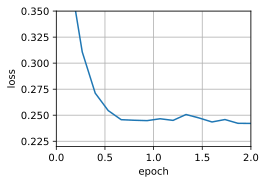

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

更简洁的实现非常简单，因为 `adam` 是作为 Gluon `trainer` 优化库的一部分提供的算法之一。因此，我们只需要为 Gluon 中的实现传递配置参数。


loss: 0.244, 0.013 sec/epoch


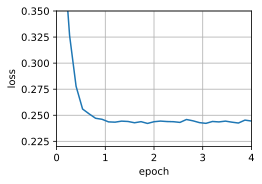

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 瑜珈修行者

亚当的问题之一是，即使在凸的环境下，它也可能无法收敛，当 $\mathbf{s}_t$ 的第二时刻估计值爆炸时。作为修复程序，:cite:`Zaheer.Reddi.Sachan.ea.2018` 提出了 $\mathbf{s}_t$ 的改进更新（和初始化）。为了了解发生了什么，让我们重写亚当更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当 $\mathbf{g}_t^2$ 具有高差异或更新稀疏时，$\mathbf{s}_t$ 可能会太快地忘记过去的值。为此可能的解决方法是将 $\mathbf{g}_t^2 - \mathbf{s}_{t-1}$ 替换为 $\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。现在，更新的规模不再取决于偏差的量。这会产生 Yogi 的更新

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

作者还建议初始化更大的初始批次的势头，而不仅仅是初始的点数估计。我们忽略了细节，因为它们对讨论并不重要，而且即使没有这种趋同，仍然相当不错。


loss: 0.242, 0.019 sec/epoch


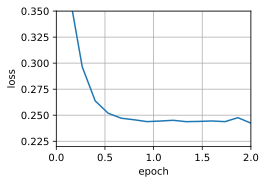

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 摘要

* Adam 将许多优化算法的功能结合到了相当强大的更新规则中。
* 亚当在 RMSProp 基础上创建的，还在迷你匹配随机梯度上使用 EWMA。
* 在估计动量和第二时刻时，亚当使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的渐变，我们可能会遇到收敛性问题。可以通过使用更大的迷你手表或者切换到改进的 $\mathbf{s}_t$ 的估计值来修改它们。Yogi 提供了这样的替代方案。

## 练习

1. 调整学习率，观察和分析实验结果。
1. 你能重写动量和第二时刻更新，以便不需要偏差校正吗？
1. 当我们收敛时，为什么你需要降低学习率 $\eta$？
1. 尝试构造一个亚当分歧和瑜伽聚合的案例？


[Discussions](https://discuss.d2l.ai/t/1078)
